In [92]:
#importing all the packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
#from xgboost import XGBRegressor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error

In [93]:
#importing data
listings = pd.read_csv("listing_update/listingsUpdateOut.csv")
neighb = pd.read_csv("neighbourhoods_update/neighbourhoods_update.csv", sep = ",")
main = pd.merge(listings, neighb, how="inner", on="neighbourhood_group")

In [105]:
#selecting variables arbitrarily
data = main[["price", "number_of_reviews",'coefficient_of_location', "host_response_rate", "population_density",
             "nr_of_bathrooms", "bedrooms", "review_scores_rating", "purchase_power_pc", "other_touristic_accomodations", "crime_rate_pc"]]

In [95]:
y = data[["price"]] #target variable
x = data[["number_of_reviews", 'coefficient_of_location', "nr_of_bathrooms", "bedrooms", "review_scores_rating", "purchase_power_pc", "crime_rate_pc", "population_density", "host_response_rate", "other_touristic_accomodations"]]

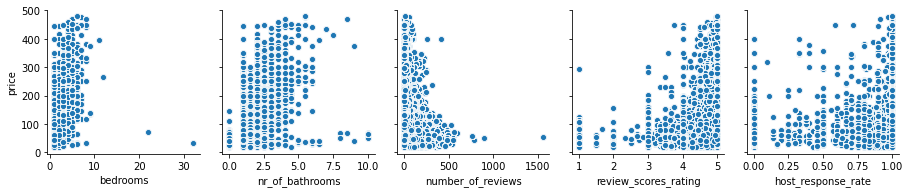

In [100]:
sns.pairplot(data, x_vars=["bedrooms", "nr_of_bathrooms", "number_of_reviews", "review_scores_rating", "host_response_rate"], y_vars=["price"], kind="scatter")

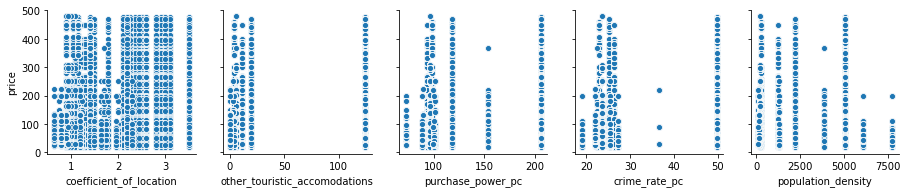

In [99]:
sns.pairplot(data, x_vars=["coefficient_of_location","other_touristic_accomodations", "purchase_power_pc", "crime_rate_pc", "population_density"], y_vars=["price"], kind="scatter")

In [101]:
x1 = sm.add_constant(x)
model = sm.OLS(y, x1)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                 1.082e+04
Date:                Wed, 27 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:09:36   Log-Likelihood:            -1.0300e+06
No. Observations:              196788   AIC:                         2.060e+06
Df Residuals:                  196777   BIC:                         2.060e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            65.8084      9.539      6.899      0.000      47.113      84.504
number_of_reviews                -0.0421      0.001    -34.143      0.000      -0.045      -0.040
coefficient_of_location           0.4385      0.195      2.250      0.024       0.057       0.820
nr_of_bathrooms                  12.1861      0.135     90.283      0.000      11.922      12.451
bedrooms                         25.7633      0.106    242.179      0.000      25.555      25.972
review_scores_rating             14.3102      0.260     55.136      0.000      13.802      14.819
purchase_power_pc                -0.1890      0.042     -4.527      0.000      -0.271      -0.107
crime_rate_pc                    -3.1373      0.298    -10.523      0.000      -3.722      -2.553
population_density               -0.0018      0.000     -5.833      0.000      -0.002      -0.001
host_response_rate              -19.7466      0.751    -26.298      0.000     -21.218     -18.275
other_touristic_accomodations     0.9155      0.088     10.416      0.000       0.743       1.088
==============================================================================
Omnibus:                    90717.645   Durbin-Watson:                   0.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4981054.579
Skew:                           1.445   Prob(JB):                         0.00
Kurtosis:                      27.477   Cond. No.                     4.56e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [106]:
#very interesting conclusions can be withdrawn from the table above
# regardless, now we will try to maximize the performance of our multilinear regression

#Removing outliers for all variables
# Outliers are defined as values > 3 standard deviations from mean
data = pd.DataFrame(data)
data_out = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
data_log = np.log(data_out)

<ipython-input-106-bc3c63ee97e8>:8: RuntimeWarning: divide by zero encountered in log
  data_log = np.log(data_out)


In [107]:
## Correlation Matrix 
df = pd.DataFrame(data_out)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,price,number_of_reviews,coefficient_of_location,host_response_rate,population_density,nr_of_bathrooms,bedrooms,review_scores_rating,purchase_power_pc,other_touristic_accomodations,crime_rate_pc
price,1.00,-0.07,-0.00,-0.01,0.00,0.33,0.55,0.18,0.00,nan,-0.00
number_of_reviews,-0.07,1.00,-0.00,0.12,-0.00,-0.08,0.02,0.13,-0.00,nan,0.00
coefficient_of_location,-0.00,-0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,0.00
host_response_rate,-0.01,0.12,0.00,1.00,0.00,-0.00,-0.00,0.10,0.00,nan,0.00
population_density,0.00,-0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,nan,1.00
nr_of_bathrooms,0.33,-0.08,0.00,-0.00,0.00,1.00,0.41,-0.01,-0.00,nan,-0.00
bedrooms,0.55,0.02,0.00,-0.00,0.00,0.41,1.00,0.07,-0.00,nan,-0.00
review_scores_rating,0.18,0.13,0.00,0.10,0.00,-0.01,0.07,1.00,0.00,nan,0.00
purchase_power_pc,0.00,-0.00,0.00,0.00,1.00,-0.00,-0.00,0.00,1.00,nan,1.00
other_touristic_accomodations,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [108]:
#Improving the original regression model
y = (data_log['price']) #target variable
x = data_out[['bedrooms','review_scores_rating', 'nr_of_bathrooms']] #predictors

# splitting training and testing data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state=1)

#fitting the model to the training data
model = lm.LinearRegression()
model.fit(x_train, y_train)


#predicting y values
y_pred = model.predict(x_test)

# Mean Squared Error
MSE = mean_squared_error(y_test,y_pred)

#Coefficient of Determination
R2 = r2_score(y_test,y_pred)


print("The new R2: ", R2)
print("The model intercept: ", model.intercept_)
print("The model coefficients: ", model.coef_)
print("The new MSE: ", MSE)

The new R2:  0.30990626065530835
The model intercept:  2.3907961227892187
The model coefficients:  [0.33986924 0.2686589  0.00667714]
The new MSE:  0.1721875941380365


In [ ]:
#I can't get this to work!!! I forgot what was the package to import to make this work

model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)

scores_s = (scores)**2

print('Mean MSE: %.3f (%.3f)' % (scores_s.mean(), scores.std()))